In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir
import ast
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
ncore

256

# Workflow starts here!

In [2]:
###################### need to change start
ipts="33592"
###################### need to change end

In [3]:
# hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
hdf5_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
sorted(os.listdir(hdf5_loc))

FileNotFoundError: [Errno 2] No such file or directory: '/HFIR/CG1D/IPTS-33592/shared/autoreduce/hdf5/'

In [4]:
###################### need to change start
sample_name = "2024_03_17_laminography_S1_lamino_735proj_gridrec"
hdf5 = hdf5_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [5]:
losa.get_hdf_tree(hdf5)
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
history_dict

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (735,)
    │   ├── ang_rad (735,)
    │   ├── fname (735,)
    │   ├── proj000_idx (1,)
    │   ├── proj180_idx (1,)
    │   └── proj360_idx (1,)
    ├── proj
    │   │
    │   ├── proj_mlog_pre_ring (735, 1100, 1846)
    │   ├── proj_mlog_pre_tilt (735, 1873, 1847)
    │   ├── proj_mlog_to_recon (735, 1100, 1846)
    │   └── proj_norm_pre_tilt (735, 1873, 1847)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 2048)
    │   ├── fluc_corr_roi_min (472, 600)
    │   ├── ob_min (2048, 2048)
    │   ├── proj_crop_roi_min (1873, 1847)
    │   └── proj_min (2048, 2048)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (1100, 1846, 1846)
    └── sino
        │
        ├── sino_mlog_pre_ring (1100, 735, 1846)
        ├── sino_mlog_pre_tilt (1873, 735, 1847)
        └── sino_mlog_to_recon (1100, 735, 1846)


{'crop': True,
 'crop_roi_dict': {'left': 200, 'right': -1, 'top': 65, 'bottom': -110},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 1,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'left': 0,
  'right': 600,
  'top': 1400,
  'bottom': -1},
 'minus_log': True,
 'tilt_corr_used': 'neutompy',
 'rot_center_180': 917.5,
 'rot_center_360': 920.5,
 'rot_center': 920.5,
 'tilt_corr_theta': -0.42852977087061767,
 'tilt_corr_shift': -13,
 'ring_rmv_roi': True,
 'ring_rmv_roi_dict': {'left': 0, 'right': -1, 'top': 0, 'bottom': 1100},
 'ring_removal': 'bm3dgpu',
 'pixel_size_um': 42,
 'recon_unit': 'cm-1',
 'start_ang_idx': 0,
 'end_ang_idx': 733,
 'recon_algo': 'gridrec',
 'recon_crop': False}

In [6]:
proj_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
# sino_mlog = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog')
sino_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_to_recon')
ang_deg = losa.load_hdf(hdf5, key_path='tomo/info/ang_deg')
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
proj000_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj000_idx')[0]
proj180_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj180_idx')[0]
proj360_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj360_idx')[0]
rot_center_used = history_dict['rot_center']
rot_center_180 = history_dict['rot_center_180']
rot_center_360 = history_dict['rot_center_360']
pixel_size_um = history_dict['pixel_size_um']
# recon_hdf5 = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')
gamma_diff = 20
# sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)
if history_dict['recon_crop']:
    recon_crop = True
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None

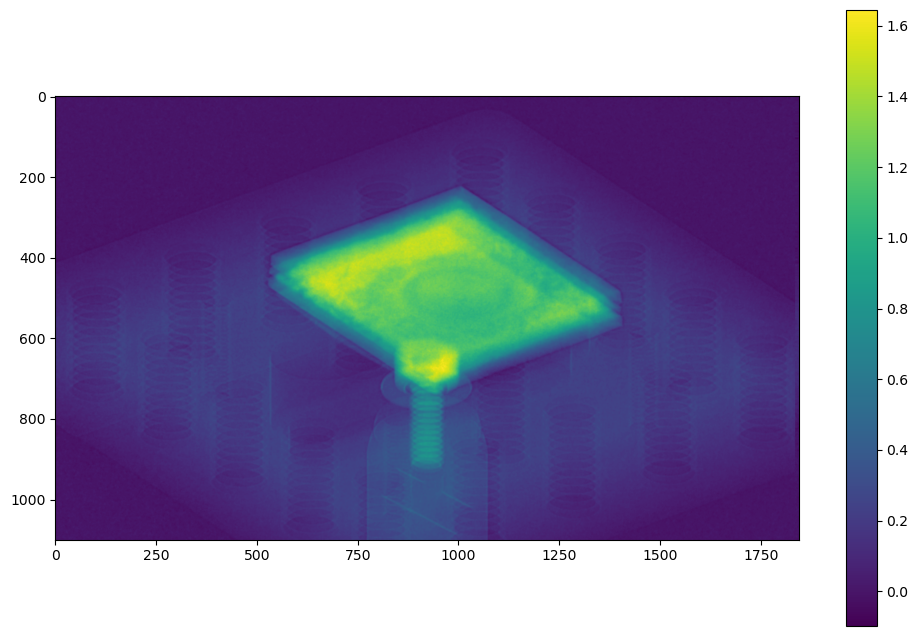

In [7]:
###################### need to change start
idx = 100
###################### need to change end
plt.imshow(proj_mlog_to_recon[idx])
plt.colorbar()
plt.show()

In [8]:
tcp_hdf5 = hdf5_loc + sample_name + '_cli' + '.h5'
print(tcp_hdf5)

/HFIR/CG1D/IPTS-32340/shared/autoreduce/hdf5/2024_03_17_laminography_S2_lamino_735proj_gridrec_test.h5


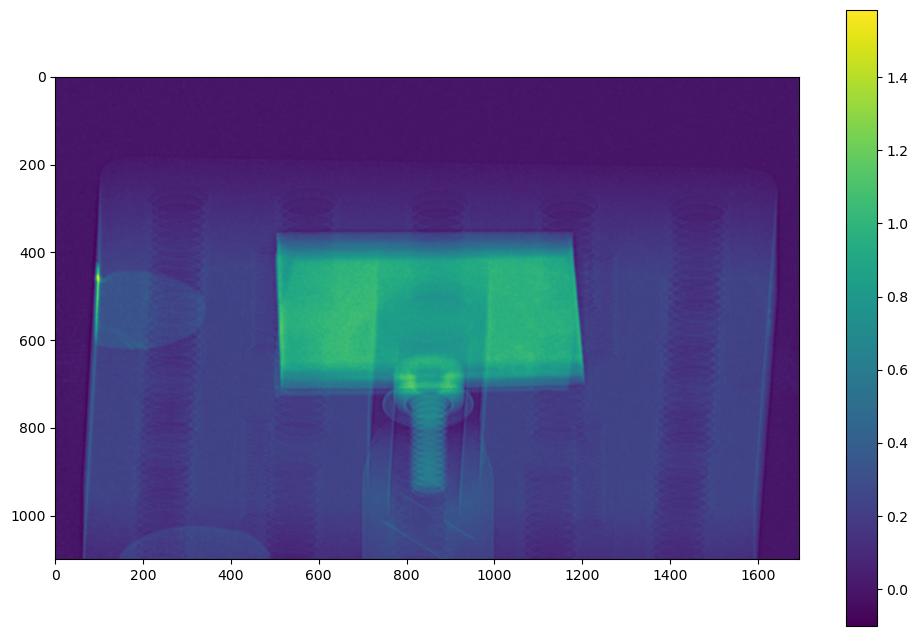

In [9]:
proj_mlog_out = proj_mlog_to_recon[:]
# proj_mlog_out = proj_mlog_to_recon[:,0:1100,:]
plt.imshow(proj_mlog_out[100])
plt.colorbar()
plt.show()

In [10]:
data_shape = proj_mlog_out.shape
dark_fake = np.zeros((1, data_shape[1], data_shape[2]), dtype=np.float32)
flat_fake = np.ones((1, data_shape[1], data_shape[2]), dtype=np.float32)

In [11]:
with h5f.File(tcp_hdf5, mode='a') as f:
    f.create_group('exchange')
    f.create_dataset('exchange/data', data=proj_mlog_out)
    f.create_dataset('exchange/data_white', data=flat_fake)
    f.create_dataset('exchange/data_dark', data=dark_fake)
    f.create_dataset('exchange/theta', data=ang_deg, dtype=np.float32)